# Make per fiber m6a density plots

In [327]:
library(ggplot2)
library(data.table)
library(dplyr)
library(tictoc)
library(ggsci)
library(purrr)


Attaching package: 'purrr'


The following object is masked from 'package:data.table':

    transpose




In [2]:
while (!is.null(dev.list()))  dev.off()
rm(list=ls())

#------------ Helper Functions ------------
# Initiate PDF
openPDF <- function (output_file_fh, pdf_dims) {
  print(sprintf("Saving plots to: %s", output_file_fh))
  # Open PDF
  pdf(output_file_fh, width = pdf_dims[1], height = pdf_dims[2],
      useDingbats=FALSE, family = "ArialMT")
}

# Close PDF
closePDF <- function () {
  while (!is.null(dev.list()))  dev.off()
  print("File saved.")
}

In [3]:
#------------ Define dirs ------------
setwd("/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting")

#ARGS
data_folder <- sprintf("%s/candidate_footprints", getwd())
mokapot_dir <- sprintf("%s/mokapot_res", getwd())
output_folder <- sprintf("%s/figures", getwd())

In [81]:
#------------ Step 1. Load data ------------

# load data file
data_file_name <- "CTCF_m6a_fiberseq_100bp_fig_example_positive.txt"
data_file <- sprintf("%s/%s", data_folder, data_file_name)
print(data_file)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/candidate_footprints/CTCF_m6a_fiberseq_100bp_fig_example_positive.txt"


In [82]:
# read table
df <- fread(data_file)
dim(df)

[1] 2165   13

In [83]:
# add motif_name row
df$motif_name <- paste(df$chrom, df$centering_position, df$strand, sep="_")
# move motif_name to first column
df <- df %>%
    select("motif_name", everything())

# add motif_query column
df <- cbind(paste(df$motif_name, df$query_name, sep="/"), df)
# rename column
colnames(df)[1] = "motif_query"

In [84]:
# get only m6a & msp rows
df <- df[df$centered_position_type %in% c("m6a", "msp")]
dim(df)

[1] 2054   15

In [85]:
# get only instances with motifs within an msp
df <- df %>%
        group_by(chrom, centering_position, strand, query_name) %>%
        filter(any(centered_position_type == "msp" & centered_start <= 0 & centered_end >= 35))
dim(df)

[1] 1878   15

In [93]:
# get only m6a instances
df <- filter(df, centered_position_type == "m6a")

### unsorted

In [581]:
# read in mokapot res
data_file_name <- "CTCF_L.mokapot.m6a_fiberseq-positive.txt"
data_file <- sprintf("%s/%s", mokapot_dir, data_file_name)
data_file

# read table
moka <- fread(data_file)
dim(moka)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/CTCF_L.mokapot.m6a_fiberseq-positive.txt"

[1] 9498533      18

In [547]:
# get motif_query instances from original data
moka <- filter(moka, motif_query %in% df$motif_query)
# rename column
names(moka)[names(moka) == "mokapot q-value"] <- "mokapot_FDR"
dim(moka)

[1] 1829   18

In [548]:
table(moka$mokapot_FDR)


0.0005441950985546 0.0006269210340714  0.000636006566338 0.0006579724326421 
                36                 33                 29                 27 
0.0007237831903387 0.0007415109090762 0.0008741929052344 0.0009068255770535 
                38                 26                 61                 83 
 0.000911064883004   0.00102436960443 0.0013416261885432 0.0013816761160607 
                24                 31                 35                 26 
0.0015099137759764 0.0017182571230733 0.0018007657993504 0.0018271054239829 
                24                 95                 99                 40 
0.0019124970505321 0.0020355987447141 0.0025839939706807 0.0026329142470541 
                23                 54                 47                 26 
0.0028668389357761 0.0029253186606575 0.0031472396312611 0.0036783969598975 
                52                 51                 40                 25 
0.0039551403814628 0.0042039752295185 0.0048083700884135 0.0048989097917963

In [562]:
# plot m6a instances in coords
motif_coords <- c("chr20", 63786415, 63786450)

In [572]:
# make plotting data
df_p <- moka[, c("motif_query", "motif_name", "query_name", "centered_start", "centered_end", "mokapot_FDR")]

In [574]:
# sort by FDR value
df_p <- df_p[order(df_p$mokapot_FDR)]

In [554]:
# create vector of 0s for m6a positions
df_m6a <- data.frame(matrix(0, ncol = 49, nrow = 201))
colnames(df_m6a) <- unique(df_p$query_name)
rownames(df_m6a) <- 1:nrow(df_m6a)

for (name in unique(df_p$query_name)) {
    # add 101 to positions to make them positive & match index
    m6a_positions <- df_p[df_p$query_name == name]$centered_start + 101
    x <- numeric(201)
    x[m6a_positions] <- 1
    df_m6a[name] <- x
}

In [495]:
# sort rows by similarity
unsorted_df <- t(df_m6a)
N <- nrow(unsorted_df)
same1 <- function(x, y) sum((x+y) == 2, na.rm=TRUE)
df_list <- unlist(apply(unsorted_df, 1, list),F,F)
df_combos <- which(upper.tri(matrix(NA, nrow=N, ncol=N)),arr.ind=T) #expand.grid(1:length(df_list),1:length(df_list))
commonality <- mapply(same1, df_list[df_combos[,1]], df_list[df_combos[,2]])
best_match <- c()
for(i in 1:length(df_list)){
    best_match[i] <- max(commonality[apply(df_combos,1,function(x)i%in%x)])
}

sorted_df <- unsorted_df[order(best_match, decreasing=TRUE),]
sorted_fibers <- rownames(sorted_df)

# sort by similarity
#df_p <- df_p %>% arrange(factor(query_name, levels=sorted_fibers))
df_p$query_name <- factor(df_p$query_name, levels=sorted_fibers)
df_p <- df_p[order(df_p$query_name)]

In [575]:
# add col with y-axis coords
y_min <- seq(from=0, by=1, length.out=length(unique(df_p$query_name)))
y_max <- seq(from=0.75, by=1, length.out=length(unique(df_p$query_name)))

y_min_vals <- setNames(y_min, unique(df_p$query_name))
y_max_vals <- setNames(y_max, unique(moka$query_name))

df_p <- df_p %>%
            mutate(
                y_min = y_min_vals[query_name],
                y_max = y_max_vals[query_name]
            )
dim(df_p)

[1] 1829    8

In [576]:
# get plot limits
x_min <- max(df_p$centered_start)
x_max <- min(df_p$centered_end)
# number of fibers
n_fibers <- length(unique(df_p$query_name))
n_fibers

[1] 49

In [567]:
# change plot dimensions
options(repr.plot.width=20, repr.plot.height=10)

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

set_plot_dimensions(15, 7.5)

In [577]:
# coords for fiber info
df_fiber <- df_p %>% 
                group_by(y_min, y_max) %>%
                summarise(
                    x_min = -100,
                    x_max = 101,
                )

`summarise()` has grouped output by 'y_min'. You can override using the
`.groups` argument.


In [502]:
# set plot parameters
plot_title <- sprintf("m6a instances per fiber (%s) over %s: %s-%s",length(unique(df_p$query_name)), motif_coords[1], motif_coords[2], motif_coords[3])
x_axis_name <- "area surrounding motif (bp)"
y_axis_name <- sprintf("%s fibers", length(unique(df_p$query_name)))
font_size <- 10
font_info <- element_text(size=font_size, family="Arial", color="black")

vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"

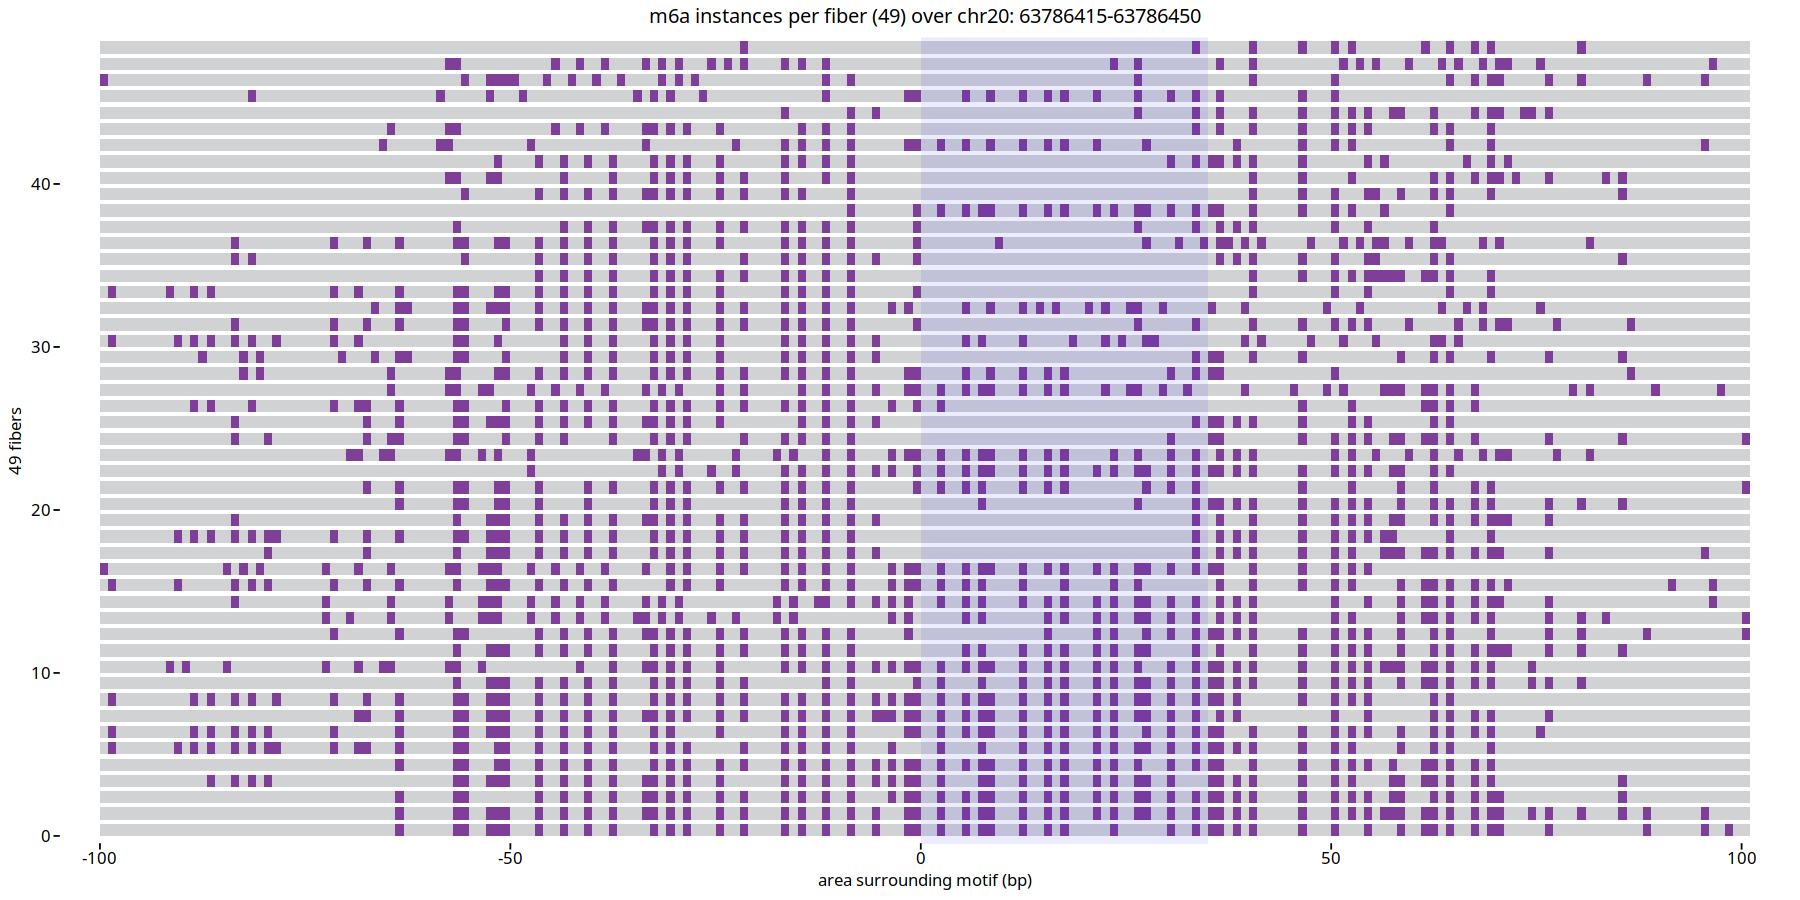

In [503]:
# plot! (sorted)

p <- ggplot(df_p) +
        geom_rect(aes(xmin=x_min, xmax=x_max, ymin=y_min, ymax=y_max), fill=fiber_col, data=df_fiber) +
        geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max), fill=m6a_col, data=df_p) +
        #geom_hline(yintercept=0, color=vline_col,
        #           show.legend=FALSE) +#, linetype="dashed") +
        #geom_vline(xintercept=0, color=vline_col,
        #           show.legend=FALSE) + #, linetype="dashed") +
        # add box over motif location
        annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.075, fill="blue") +
        #coord_cartesian(ylim=c(0, 50)) +
        scale_y_continuous(limits=c(0, 49), expand=expansion(add=c(0.5,0)), name=y_axis_name) +
        ggtitle(plot_title) +
        scale_x_continuous(name=x_axis_name, expand=expansion(add=c(5, 5))) +
        theme_classic() +
            theme(text = font_info,
            axis.ticks = element_line(color="#000000", lineend="square"),
            axis.text = font_info,
            axis.line = element_blank(),
            panel.background = element_blank(), #element_rect(fill="transparent",
                               #             color="#000000", size=1),
            #plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm"),
            plot.title = element_text(family="Arial", size=12, hjust=0.5),
            legend.position = "none")
p

### colored & sorted by FDR

In [582]:
# read in mokapot res
data_file_name <- "CTCF_L.mokapot.m6a_fiberseq-positive.txt"
data_file <- sprintf("%s/%s", mokapot_dir, data_file_name)
data_file

# read table
moka <- fread(data_file)
dim(moka)

[1] "/mmfs1/gscratch/stergachislab/mvollger/projects/ctcf-footprinting/mokapot_res/CTCF_L.mokapot.m6a_fiberseq-positive.txt"

[1] 9498533      18

In [595]:
# get motif_query instances from original data
moka <- filter(moka, motif_query %in% df$motif_query)
# rename column
names(moka)[names(moka) == "mokapot q-value"] <- "mokapot_FDR"
dim(moka)

[1] 1829   18

In [596]:
# plot m6a instances in coords
motif_coords <- c("chr20", 63786415, 63786450)

In [607]:
# make plotting data
df_p <- moka[, c("motif_query", "motif_name", "query_name", "centered_start", "centered_end", "mokapot_FDR")]

In [608]:
# sort by FDR value
df_p <- df_p[order(df_p$mokapot_FDR)]
#df_p$query_name <- factor(df_p$mokapot_FDR, levels=unique(df_p$query_name))
#df_p <- df_p[order(df_p$query_name)]

In [609]:
# add col with y-axis coords
y_min <- seq(from=0, by=1, length.out=length(unique(df_p$query_name)))
y_max <- seq(from=0.75, by=1, length.out=length(unique(df_p$query_name)))

y_min_vals <- setNames(y_min, unique(df_p$query_name))
y_max_vals <- setNames(y_max, unique(df_p$query_name))

df_p <- df_p %>%
            mutate(
                y_min = y_min_vals[query_name],
                y_max = y_max_vals[query_name]
            )
dim(df_p)

[1] 1829    8

In [610]:
# get plot limits
x_min <- max(df_p$centered_start)
x_max <- min(df_p$centered_end)
# number of fibers
n_fibers <- length(unique(df_p$query_name))
n_fibers

[1] 49

In [611]:
# coords for fiber info
df_fiber <- df_p %>% 
                group_by(y_min, y_max) %>%
                summarise(
                    x_min = -100,
                    x_max = 101,     
                )

`summarise()` has grouped output by 'y_min'. You can override using the
`.groups` argument.


In [612]:
# add color based on FDR value
# red, blue
fill_cols <- c("#be282d", "#2a3d8c")
FDR_threshold <- 0.01

df_p$fill_col <- ifelse(df_p$mokapot_FDR <= FDR_threshold, fill_cols[1], fill_cols[2])
df_p$FDR_group <- ifelse(df_p$mokapot_FDR <= FDR_threshold, "low_FDR", "high_FDR")

In [613]:
# set plot parameters
plot_title <- sprintf("m6a instances per fiber (%s) over %s: %s-%s\nFDR < %s", 
                length(unique(df_p$query_name)), motif_coords[1], motif_coords[2], motif_coords[3], FDR_threshold)
x_axis_name <- "area surrounding motif (bp)"
y_axis_name <- sprintf("%s fibers", length(unique(df_p$query_name)))
font_size <- 10
font_info <- element_text(size=font_size, family="Arial", color="black")

vline_col <- "#CECDCC"
m6a_col <- "#7F3F98"
fiber_col <- "#D1D2D4"

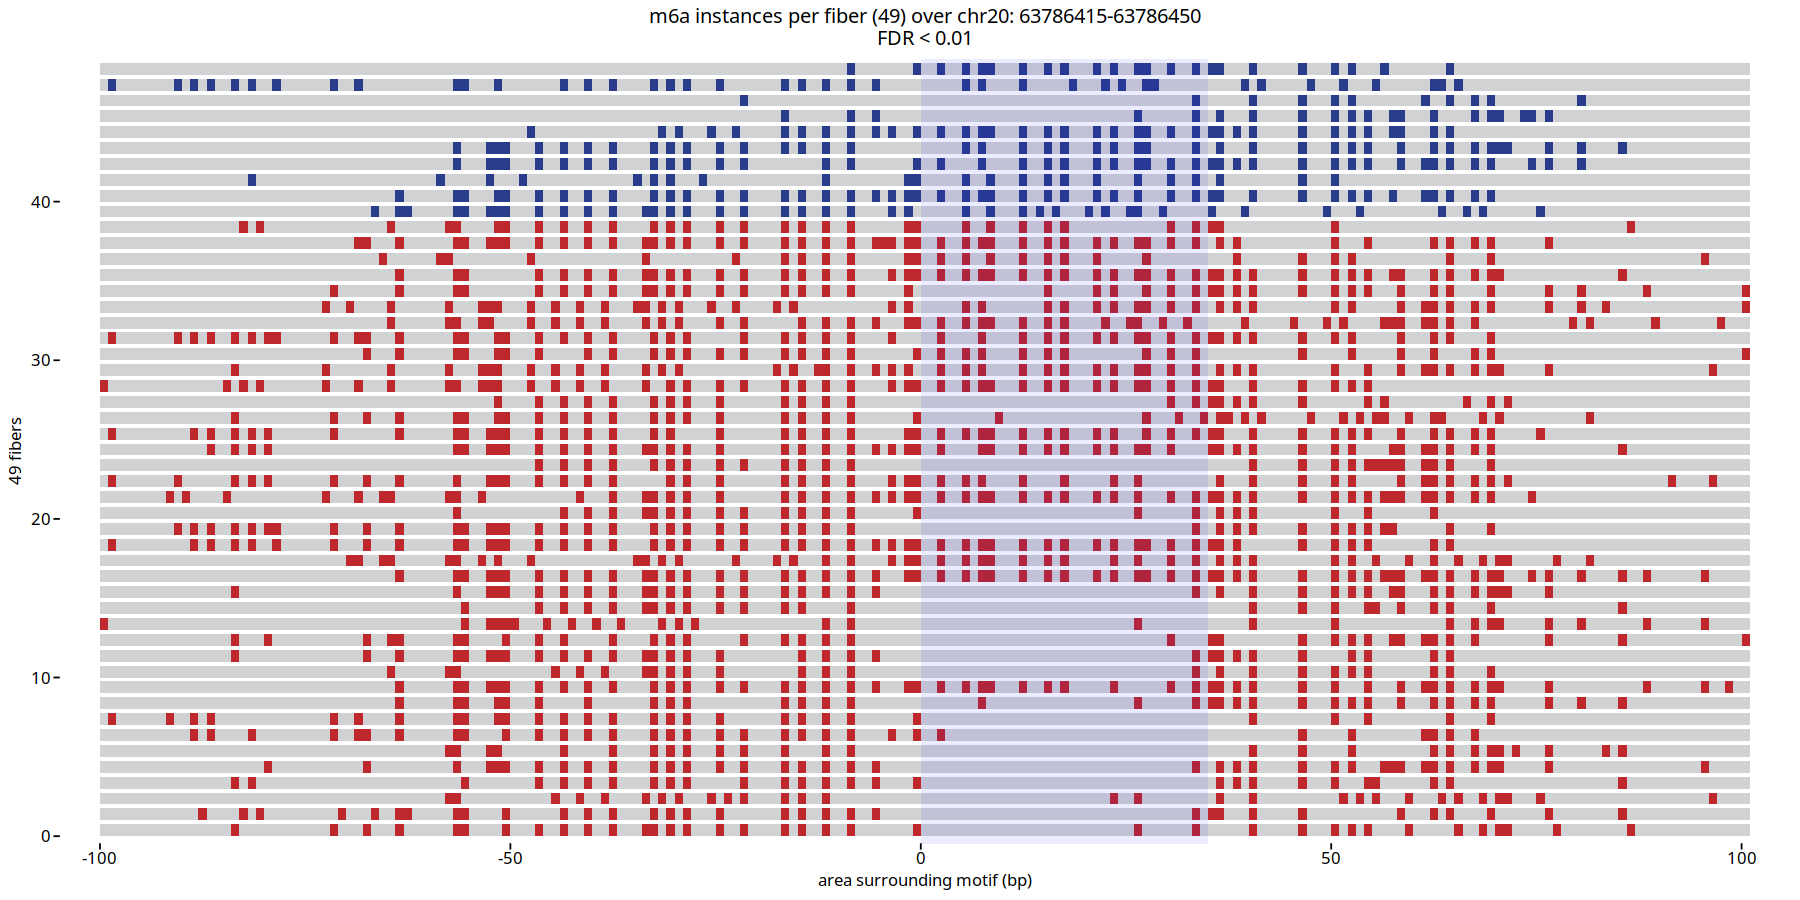

In [614]:
# plot (colored by FDR)

p <- ggplot(df_p) +
        geom_rect(aes(xmin=x_min, xmax=x_max, ymin=y_min, ymax=y_max), fill=fiber_col, data=df_fiber) +
        geom_rect(aes(xmin=centered_start, xmax=centered_end, ymin=y_min, ymax=y_max, group=FDR_group), fill=df_p$fill_col, data=df_p) +
        scale_color_identity() +
        # add box over motif location
        annotate("rect", xmin=0, xmax=35, ymin=-Inf, ymax=+Inf, alpha=0.075, fill="blue") +
        #coord_cartesian(ylim=c(0, 50)) +
        scale_y_continuous(limits=c(0, 49), expand=expansion(add=c(0.5,0)), name=y_axis_name) +
        ggtitle(plot_title) +
        scale_x_continuous(name=x_axis_name, expand=expansion(add=c(5, 5))) +
        theme_classic() +
            theme(text = font_info,
            axis.ticks = element_line(color="#000000", lineend="square"),
            axis.text = font_info,
            axis.line = element_blank(),
            panel.background = element_blank(), #element_rect(fill="transparent",
                               #             color="#000000", size=1),
            #plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm"),
            plot.title = element_text(family="Arial", size=12, hjust=0.5),
            legend.position = "none")
p

In [631]:
dim(df_p)
length(unique(df_p[1:450]$query_name))

[1] 1829   10

[1] 15

In [632]:
sort(unique(df_p[1:450]$mokapot_FDR))

[1] 0.0005441951 0.0006269210 0.0006360066 0.0006579724 0.0007237832
 [6] 0.0007415109 0.0008741929 0.0009068256 0.0009110649 0.0010243696
[11] 0.0013416262 0.0013816761 0.0015099138